# Setup Librerie e Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import sklearn.model_selection as sk

In [ ]:
from sklearn.metrics import mean_squared_error

import calendar

import holidays

import prophet
from prophet import Prophet


In [ ]:
pip install pmdarima

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

seed=42

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)


<ipython-input-43-6682045aadf4>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [ ]:
df = pd.read_csv('/content/leads2.csv', sep=";")
pd.set_option('display.max_rows', None)

# Visualizza il DataFrame df
df.head()

,data,leads
0,01/01/2022,686
1,02/01/2022,1960
2,03/01/2022,2771
3,04/01/2022,2810
4,05/01/2022,2552


In [ ]:
df['data'] = pd.to_datetime(df['data'], dayfirst=True)  # Se le date sono principalmente in formato giorno-mese-anno
df.set_index('data', inplace=True)

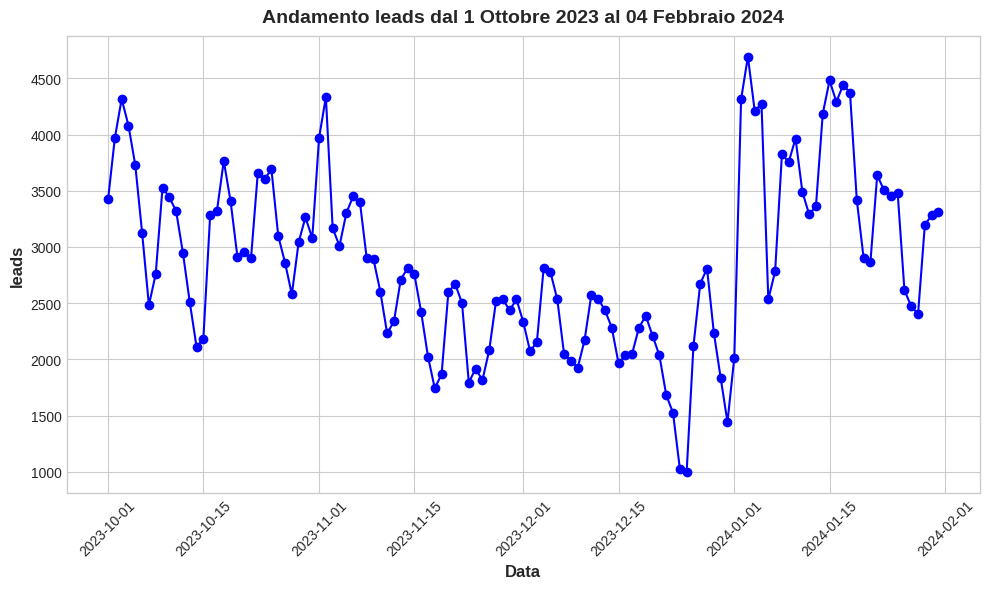

In [ ]:


# Filtra il DataFrame per l'intervallo di date specificato
start_date = '2023-10-01'
end_date = '2024-01-31'
df_filtered = df.loc[start_date:end_date]

# Crea il grafico
plt.figure(figsize=(10, 6))
plt.plot(df_filtered.index, df_filtered['leads'], marker='o', linestyle='-', color='blue')
plt.title('Andamento leads dal 1 Ottobre 2023 al 04 Febbraio 2024')
plt.xlabel('Data')
plt.ylabel('leads')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#today = df['data'].iloc[-1]
#tomorrow = today + pd.DateOffset(days=1)


# Setup holdays

In [ ]:
is_holiday = [1 if x==True else 0 for x in [day in holidays.Italy() for day in df.index]]
df['holiday'] = is_holiday


In [ ]:
df.tail()

,leads,holiday
data,,
2024-01-31,3313,0
2024-02-01,3888,0
2024-02-02,3220,0
2024-02-03,2746,0
2024-02-04,2927,0


# Forecasting con Prophet

In [ ]:
prediction_window = 28 #testing window (4 weeks of data)
forecast_window = 7 # forecasting window (1 week)
window = prediction_window + forecast_window #prediction + forecasting window


In [ ]:
df_p = df['leads'].reset_index().copy()
df_p = df_p.rename(columns={'data': 'ds', 'leads': 'y'})
df_p.set_index('ds', inplace=True)


# Ordina il DataFrame per l'indice corretto
df_p.sort_index(inplace=True)
df_p.head()


,y
ds,
2022-01-01,686
2022-01-02,1960
2022-01-03,2771
2022-01-04,2810
2022-01-05,2552


In [ ]:
df_p.reset_index(inplace=True)
pd.set_option('display.max_rows', 5)


In [ ]:
prophet_model = Prophet(n_changepoints=50, # hyperparameter
                        seasonality_mode='multiplicative',
                       changepoint_prior_scale=10) # hyperparameter


In [ ]:
df_p.tail()

,ds,y
760,2024-01-31,3313
761,2024-02-01,3888
762,2024-02-02,3220
763,2024-02-03,2746
764,2024-02-04,2927


In [ ]:
prophet_model.add_seasonality('weekly', period = 7, fourier_order = 5)
prophet_model.add_seasonality('yearly', period = 365, fourier_order = 25)
prophet_model.add_country_holidays(country_name='Italy')
prophet_model.fit(df_p)


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu5y7rhpa/76tmsqei.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu5y7rhpa/cgawc2kx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30765', 'data', 'file=/tmp/tmpu5y7rhpa/76tmsqei.json', 'init=/tmp/tmpu5y7rhpa/cgawc2kx.json', 'output', 'file=/tmp/tmpu5y7rhpa/prophet_models1t68kux/prophet_model-20240205175806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:58:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:58:09 - cmdstanpy - INFO - Chain [1] done proc

## Forecasting

In [ ]:
future = prophet_model.make_future_dataframe(periods=forecast_window)



In [ ]:
forecast = prophet_model.predict(future)


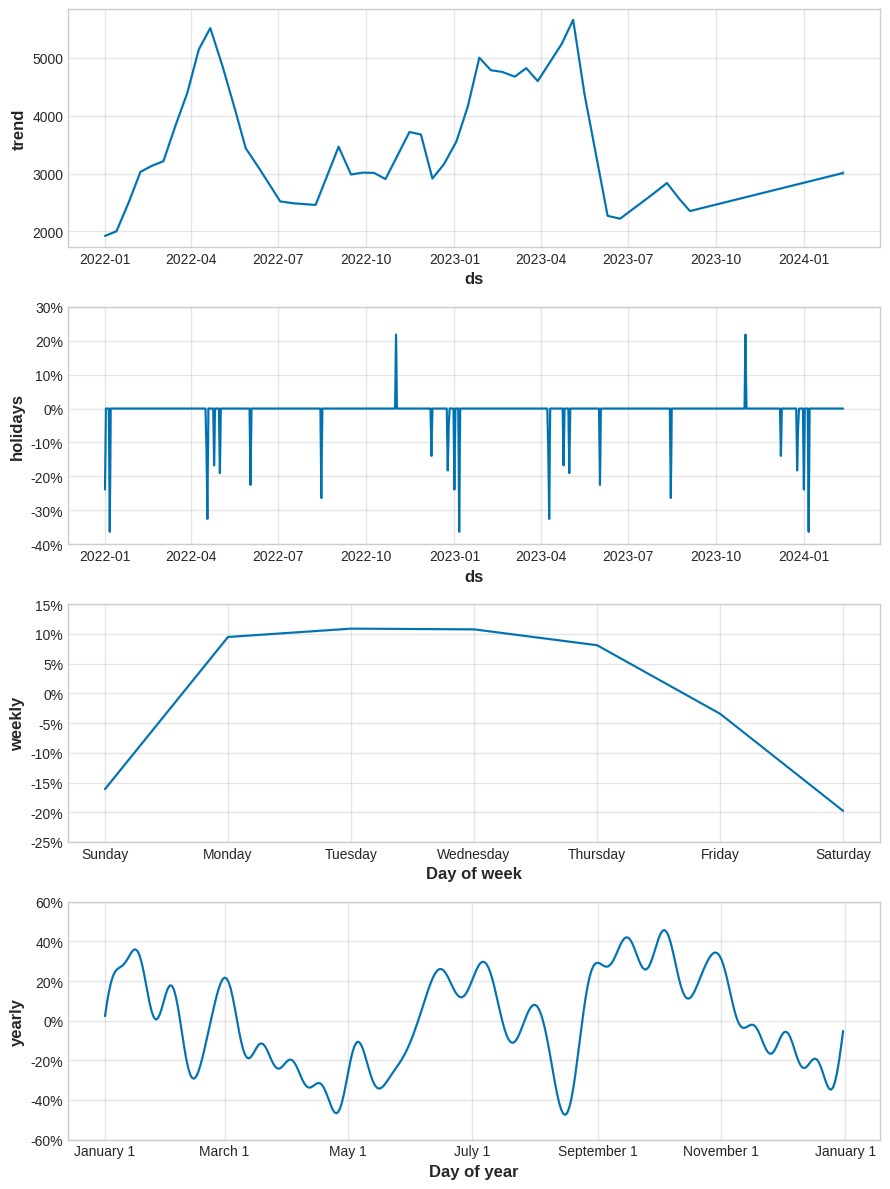

In [ ]:
fig = prophet_model.plot_components(forecast)


In [ ]:
forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


In [ ]:
forecast_df

,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01,1261.501865,679.605776,1850.436528
1,2022-01-02,1909.006441,1326.184176,2440.277286
...,...,...,...,...
770,2024-02-10,1699.335544,1214.056734,2249.184480
771,2024-02-11,1710.040325,1101.735367,2256.970957


In [ ]:
df_final = pd.DataFrame({'date':forecast_df[-window:]['ds'], 'y_p':forecast_df[-window:]['yhat']})
df_final = df_final.set_index('date')
df_final['y_avg'] = df_final.mean(axis=1)


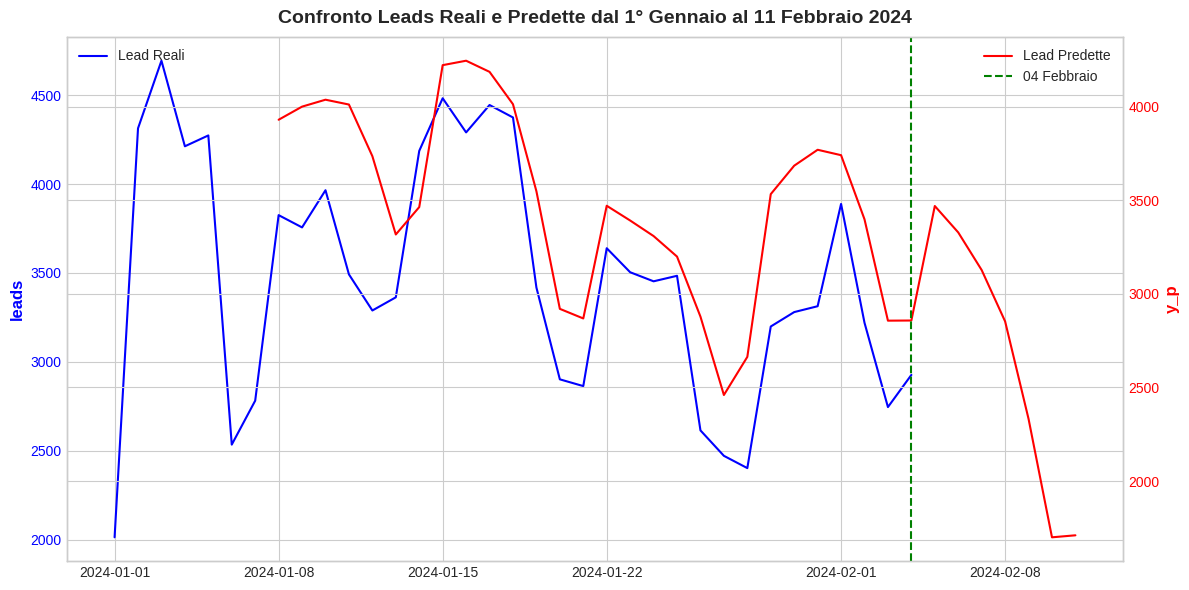

In [ ]:
# Filtra per l'orizzonte temporale specificato
start_date = '2024-01-01'
end_date = '2024-02-11'

df_filtered = df.loc[start_date:end_date]
df_final_filtered = df_final.loc[start_date:end_date]

# Crea il grafico
plt.figure(figsize=(12, 6))

# Primo asse y per "df"
ax1 = plt.gca()  # Get current axis
ax1.plot(df_filtered.index, df_filtered['leads'], color='blue', label='Lead Reali')
ax1.set_ylabel('leads', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Secondo asse y per "df_final"
ax2 = ax1.twinx()  # Crea un secondo asse y che condivide lo stesso asse x
ax2.plot(df_final_filtered.index, df_final_filtered['y_p'], color='red', label='Lead Predette')
ax2.set_ylabel('y_p', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Aggiungi una linea verticale al 15 gennaio 2024
plt.axvline(pd.to_datetime('2024-02-04'), color='green', linestyle='--', label='04 Febbraio')

# Titolo e legenda
plt.title('Confronto Leads Reali e Predette dal 1° Gennaio al 11 Febbraio 2024')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

Il modello va, ma è molto rudimentale. Va migliorato per:
- Distinguere consulenti e GDO
  - Divisione Leads parziali e complete
- Aumentare la precisione:
  - Aggiungere i dati risalenti ad almeno 1 anno fa
  - Suddividere per Acquisto / Surroga / Altre finalità
  - Testare almeno un altro modello (SARIMAX / Auto ARIMA / Neural Prophet)
- Aumentare la completezza
  - Aggiungere altre campagne leads, come l'organico e il direct
  - Aggiungere CRM e facebook come fattori esogeni

In [ ]:
# Definisci gli intervalli di date
start_df = '2024-01-01'
end_df = '2024-01-15'
start_df_final = '2024-02-01'
end_df_final = '2024-02-15'

# Filtra i DataFrame per le date specificate
df_filtered = df.loc[start_df:end_df]
df_final_filtered = df_final.loc[start_df_final:end_df_final]

# Visualizza i DataFrame filtrati
print("Valori per df dal 1 al 15 Gennaio 2024:")
display(df_filtered)

print("\nValori per df_final dall'1 al 15 Febbraio 2024:")
display(df_final_filtered)

Valori per df dal 1 al 15 Gennaio 2024:


,leads,holiday
data,,
2024-01-01,2014,1
2024-01-02,4313,0
...,...,...
2024-01-14,4186,0
2024-01-15,4482,0



Valori per df_final dall'1 al 15 Febbraio 2024:


,y_p,y_avg
date,,
2024-02-01,3740.404895,3740.404895
2024-02-02,3397.900694,3397.900694
...,...,...
2024-02-10,1699.335544,1699.335544
2024-02-11,1710.040325,1710.040325


In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np

# Unisci i DataFrame basandoti sugli indici di date
# Assumendo che gli indici siano già in formato datetime e allineati per il confronto
df_merged = pd.merge(df[['leads']], df_final[['y_p']], left_index=True, right_index=True, how='inner')

# Calcola l'MSE usando solo le righe con valori sia in 'leads' che in 'y_p'
mse = mean_squared_error(df_merged['leads'], df_merged['y_p'])

# Calcola l'RMSE
rmse = np.sqrt(mse)

print(f"L'RMSE per i giorni allineati è: {rmse}")


L'RMSE per i giorni allineati è: 279.4747606261615


In [ ]:
import math

# Calcola la somma degli ultimi 7 valori
somma_ultimi_7 = df_final['y_p'].tail(7).sum()

# Arrotonda per eccesso
somma_arrotondata = math.ceil(somma_ultimi_7)

print("Avrai "+str(somma_arrotondata) + " leads la prossima settimana, senza considerare CRM.")

Avrai 18518 leads la prossima settimana, senza considerare CRM.
